In [40]:
from IPython.display import Image

## HEALPix

HEALPix (Hierarchical Equal Area isoLatitude Pixelization) is a useful method for divding a sphere into tiles of equal area, such that the tiles are also arranged in ways that can make certain computations on the sphere very efficient. 

It was created by astronomers studying the cosmic microwave background radiation, but also gets used in environmental data analysis. (See e.g. Gorski, K. M., Hivon, E., Banday, A. J., Wandelt, B. D., Hansen, F. K., Reinecke, M., & Bartelmann, M. (2005). HEALPix: A framework for high-resolution discretization and fast analysis of data distributed on the sphere. The Astrophysical Journal)

One recent high profile use of it was by DeepMind in a recent paper where they train neural networks to compress atmospheric data: https://arxiv.org/abs/2407.11666

### Resources:
HEALPix website: https://healpix.jpl.nasa.gov/ \
The HEALPix primer: https://arxiv.org/abs/astro-ph/9905275 \
healpy documentation: https://healpy.readthedocs.io/en/latest/ \
astropy_healpix docs: https://astropy-healpix.readthedocs.io/

The basic idea, is that the sphere is first divided into 12 pixels of equal area; these can then be successively subdivided to create finer and finer resolutions. Whatever the resolution though, the pixels always have the same area (unlike e.g. Lat/Lon grids where the area decreases towards the poles)

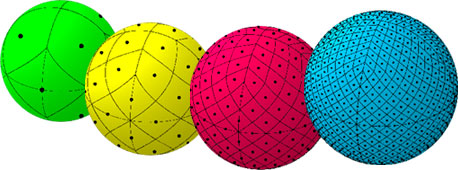

In [44]:
Image(filename='HealpixGridRefinement.jpg') # [Image By NASA and Caltech]

We will use the healpy package here, although there is also the astropy_healpix package. Much of this tutorial follows the healpy tutorial found here: https://healpy.readthedocs.io/en/latest/tutorial.html

In [17]:
import os
import numpy as np
import healpy as hp
from pathlib import Path
import matplotlib.pyplot as plt

notebook_dir = os.getcwd()
data_dir = str(Path(notebook_dir).parents[1] / 'data_samples' / 'healpix')

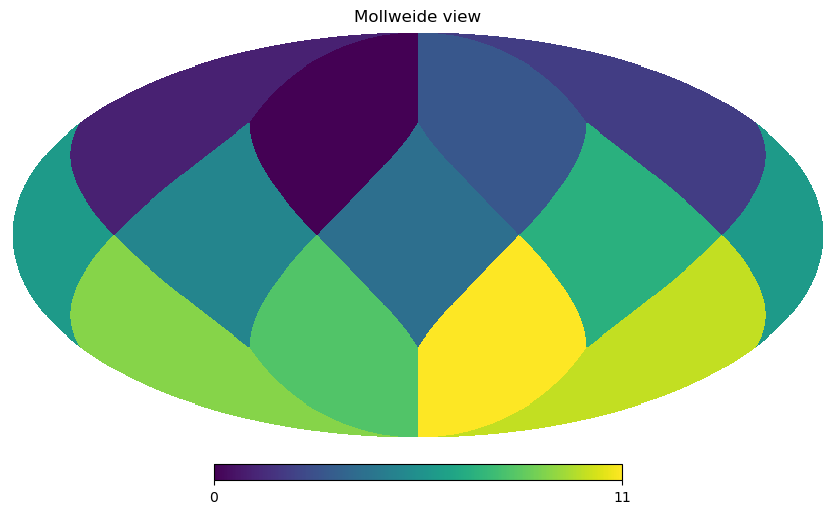

In [36]:
# A key parameter is NSIDE, a power of 2 which determines how many times the original 12 tiles are subdivided.
# Let's look at NSIDE=1, which is the basic tiling of the sphere with 12 tiles
NSIDE=1
NPIX = hp.nside2npix(NSIDE)

m = np.arange(NPIX)

# show a map where each pixel is coloured according to its index, using the Mollweide projection
hp.mollview(m)

There are two ways of ordering the points in HEALPix; in Ring ordering or 'Nested' ordering. Each one has different uses, and can make certain computations more efficient. 

The 'Ring' ordering means that pixels are indexed from top to bottom and left to right. This is the default ordering, and is used to perform Spherical Harmonic transforms.

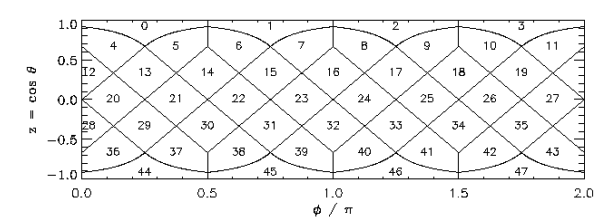

In [43]:
Image(filename='ring_ordering.png') # Source: Gorski, Krzysztof M., et al. "The healpix primer." arXiv astro-ph/9905275 (1999).

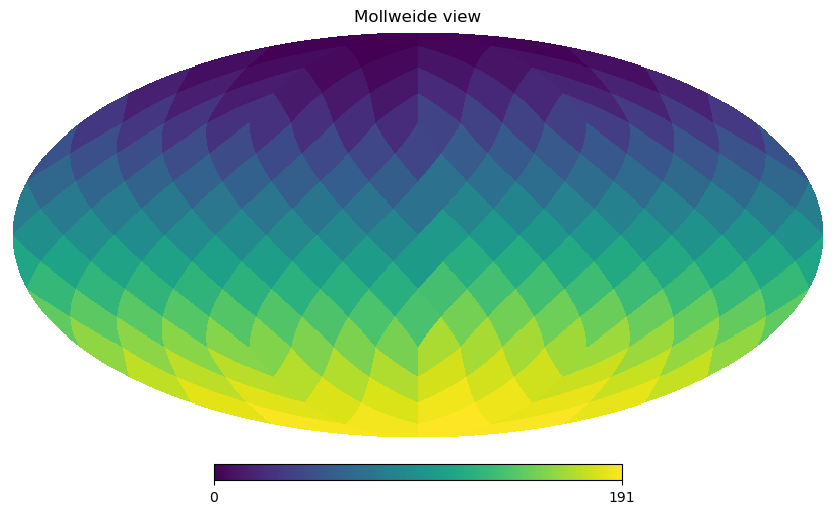

In [3]:
# The colours on this plot show how the indexes are arranged on the sphere; darker areas indicate low indexes and light areas indicate high indexes. Note how the index value generally increases from top to bottom (and left to right, although it is harder to tell from this image, but observe the discontinuity at the central line)

NSIDE=4
NPIX = hp.nside2npix(NSIDE)

m = np.arange(NPIX)
hp.mollview(m, nest=False)

The 'Nested' ordering means that pixels are indexed in a heirarchical way; starting from the largest scale and progressing downwards. 

This type of ordering is useful for operations that require grouping over areas on the sphere

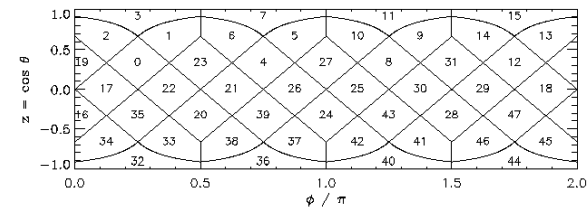

In [46]:
Image(filename='nest_ordering.png') # Source: Gorski, Krzysztof M., et al. "The healpix primer." arXiv astro-ph/9905275 (1999).

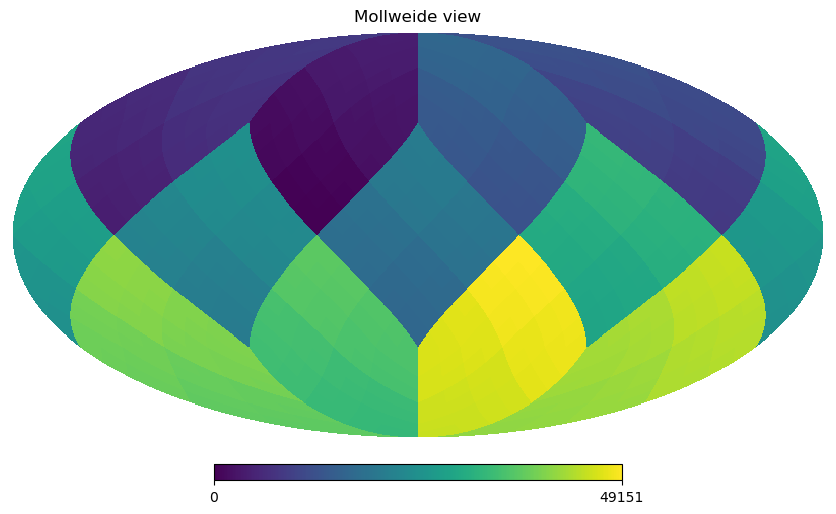

In [38]:
# Again, darker areas indicate low indexes and light areas indicate high indexes. Note how for the nested case, each tile is located near others with similar indexes
NSIDE=64
NPIX = hp.nside2npix(NSIDE)

m = np.arange(NPIX)
hp.mollview(m, nest=True)

## Load data

In [13]:
wmap_map_I = hp.read_map(os.path.join(data_dir, 'wmap_band_iqumap_r9_7yr_W_v4.fits'))

In [46]:
# Find the NSIDE parameter for this data
map_nside = hp.npix2nside(wmap_map_I.shape[0])
print(map_nside)

512


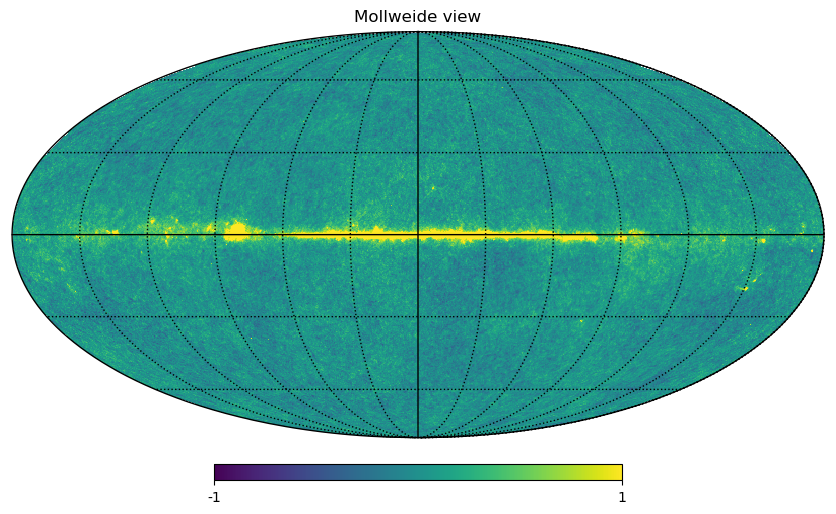

In [22]:
hp.mollview(
    wmap_map_I,
    min=-1,
    max=1,
)
hp.graticule()

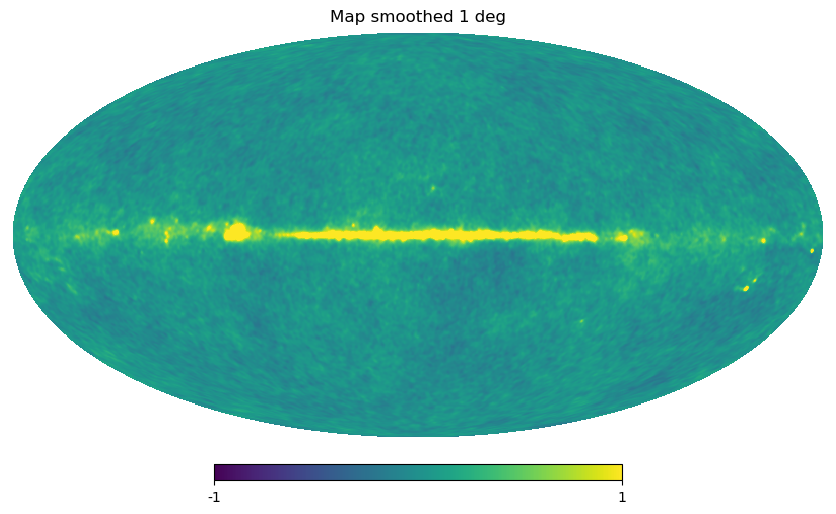

In [23]:
# Gaussian smoothing
wmap_map_I_smoothed = hp.smoothing(wmap_map_I, fwhm=np.radians(1.))
hp.mollview(wmap_map_I_smoothed, min=-1, max=1, title="Map smoothed 1 deg")

In [47]:
# Find nearest pixels to a particular point
vec = hp.ang2vec(np.pi / 4, 0)
ipix_disc = hp.query_disc(nside=map_nside, vec=vec, radius=np.radians(10))

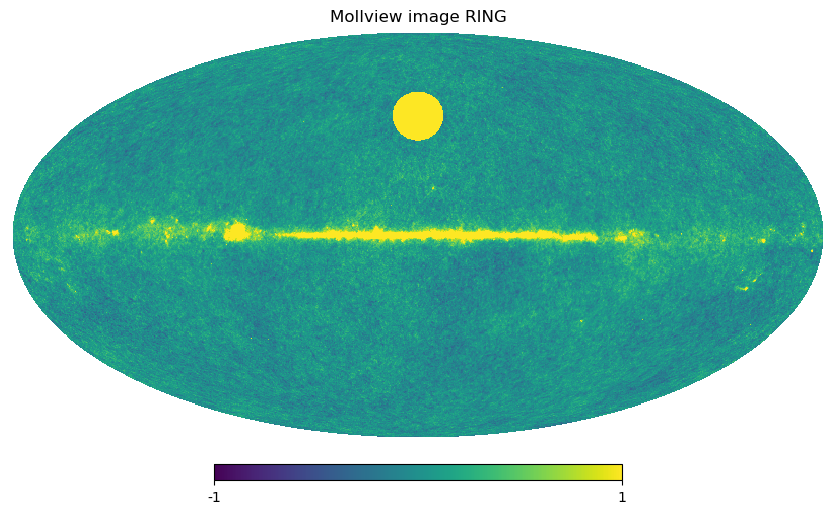

In [49]:
# Demonstrate this by setting all points around (pi/4,0) to 1
map = wmap_map_I.copy()
map[ipix_disc] = 1
hp.mollview(map, min=-1,
    max=1,title="Mollview image RING")

## Spherical Harmonic Transform

In [19]:
LMAX = 1024
cl = hp.anafast(wmap_map_I, lmax=LMAX)
ell = np.arange(len(cl))

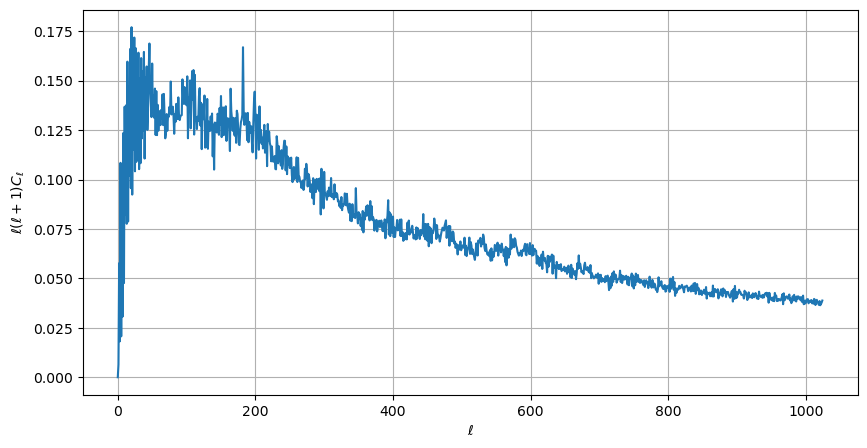

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(ell, ell * (ell + 1) * cl)
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")
plt.grid()
hp.write_cl("cl.fits", cl, overwrite=True)